# Project Title
### Data Engineering Capstone Project

#### Project Summary
The scope of the project is to provide a thorough analysis on the United States flights
affected by coronavirus

#### Data Sources

For the project the following data sources were used:

* US flight information provided by [transtats](https://www.transtats.bts.gov/)
  The reports contain flight information for months January and Februrary 2020
* Corona virus data provided by [EU Open Data Portal](https://data.europa.eu/)
  The report contains up to date data for all global corona virus cases


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [10]:
# Do all imports and installs here
import pandas as pd

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>
The data gathered will be preprocessed using spark and stored in partitioned parquet format
in Amazon s3. The data will be later copied to redshift to provide analytical insights.
For the data pipeline Apache airflow will be used and for the spark implementation
an EMR cluster will be created that will be launched through airflow to optimally shutdown the resources
when they are not needed. Lastly Livy will be used to easily submit spark jobs over REST.

The original data will be stored in s3 and will be used as the starting point for this project. In a real life scenario
a small script could be invoked to download the files from the equivalent websites and uploaded to s3. For simplicity this is step
is ignored for now and all the raw data already reside in an s3 bucket

#### Describe and Gather Data 

In [11]:
from pyspark.sql.types import StructField, DateType, StringType, IntegerType, FloatType, BooleanType, StructType
pd.options.display.max_columns = None
import pyspark.sql.functions as F

In [12]:
# Read in the data here
flights_jan = 'data/flights_2020_01.csv'
flights_feb = 'data/flights_2020_02.csv'
cname= 'data/download.json'
df_flights_january = pd.read_csv(flights_jan,sep="," )
df_flights_february = pd.read_csv(flights_feb,sep="," )
covid = pd.read_json(cname)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# View the first records
df_flights_january.head()

,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,CANCELLED,CANCELLATION_CODE,Unnamed: 31
0,2020-01-01,WN,N951WN,13891,1389101,32575,ONT,"Ontario, CA",CA,6,California,91,14771,1477104,32457,SFO,"San Francisco, CA",CA,6,California,91,1851.0,41.0,41.0,1.0,2053.0,68.0,68.0,1.0,0.0,NaN,NaN
1,2020-01-01,WN,N467WN,13891,1389101,32575,ONT,"Ontario, CA",CA,6,California,91,14771,1477104,32457,SFO,"San Francisco, CA",CA,6,California,91,1146.0,-4.0,0.0,0.0,1318.0,-2.0,0.0,0.0,0.0,NaN,NaN
2,2020-01-01,WN,N7885A,13891,1389101,32575,ONT,"Ontario, CA",CA,6,California,91,14831,1483106,32457,SJC,"San Jose, CA",CA,6,California,91,2016.0,-4.0,0.0,0.0,2124.0,-6.0,0.0,0.0,0.0,NaN,NaN
3,2020-01-01,WN,N551WN,13891,1389101,32575,ONT,"Ontario, CA",CA,6,California,91,14831,1483106,32457,SJC,"San Jose, CA",CA,6,California,91,1350.0,10.0,10.0,0.0,1505.0,10.0,10.0,0.0,0.0,NaN,NaN
4,2020-01-01,WN,N968WN,13891,1389101,32575,ONT,"Ontario, CA",CA,6,California,91,14831,1483106,32457,SJC,"San Jose, CA",CA,6,California,91,916.0,1.0,1.0,0.0,1023.0,-12.0,0.0,0.0,0.0,NaN,NaN


In [13]:
#Count the data retrieved
df_flights_january.count()

FL_DATE                  607346
OP_UNIQUE_CARRIER        607346
TAIL_NUM                 606648
ORIGIN_AIRPORT_ID        607346
ORIGIN_AIRPORT_SEQ_ID    607346
ORIGIN_CITY_MARKET_ID    607346
ORIGIN                   607346
ORIGIN_CITY_NAME         607346
ORIGIN_STATE_ABR         607346
ORIGIN_STATE_FIPS        607346
ORIGIN_STATE_NM          607346
ORIGIN_WAC               607346
DEST_AIRPORT_ID          607346
DEST_AIRPORT_SEQ_ID      607346
DEST_CITY_MARKET_ID      607346
DEST                     607346
DEST_CITY_NAME           607346
DEST_STATE_ABR           607346
DEST_STATE_FIPS          607346
DEST_STATE_NM            607346
DEST_WAC                 607346
DEP_TIME                 600682
DEP_DELAY                600647
DEP_DELAY_NEW            600647
DEP_DEL15                600647
ARR_TIME                 600271
ARR_DELAY                599268
ARR_DELAY_NEW            599268
ARR_DEL15                599268
CANCELLED                607346
CANCELLATION_CODE          6928
Unnamed:

In [14]:
#Count the data retrieved
df_flights_february.count()

FL_DATE                  574268
OP_UNIQUE_CARRIER        574268
TAIL_NUM                 573835
ORIGIN_AIRPORT_ID        574268
ORIGIN_AIRPORT_SEQ_ID    574268
ORIGIN_CITY_MARKET_ID    574268
ORIGIN                   574268
ORIGIN_CITY_NAME         574268
ORIGIN_STATE_ABR         574268
ORIGIN_STATE_FIPS        574268
ORIGIN_STATE_NM          574268
ORIGIN_WAC               574268
DEST_AIRPORT_ID          574268
DEST_AIRPORT_SEQ_ID      574268
DEST_CITY_MARKET_ID      574268
DEST                     574268
DEST_CITY_NAME           574268
DEST_STATE_ABR           574268
DEST_STATE_FIPS          574268
DEST_STATE_NM            574268
DEST_WAC                 574268
DEP_TIME                 569330
DEP_DELAY                569317
DEP_DELAY_NEW            569317
DEP_DEL15                569317
ARR_TIME                 568981
ARR_DELAY                568076
ARR_DELAY_NEW            568076
ARR_DEL15                568076
CANCELLED                574268
CANCELLATION_CODE          5135
Unnamed:

In [15]:
#Count the data retrieved
covid.head()
covid.count()

records    16322
dtype: int64

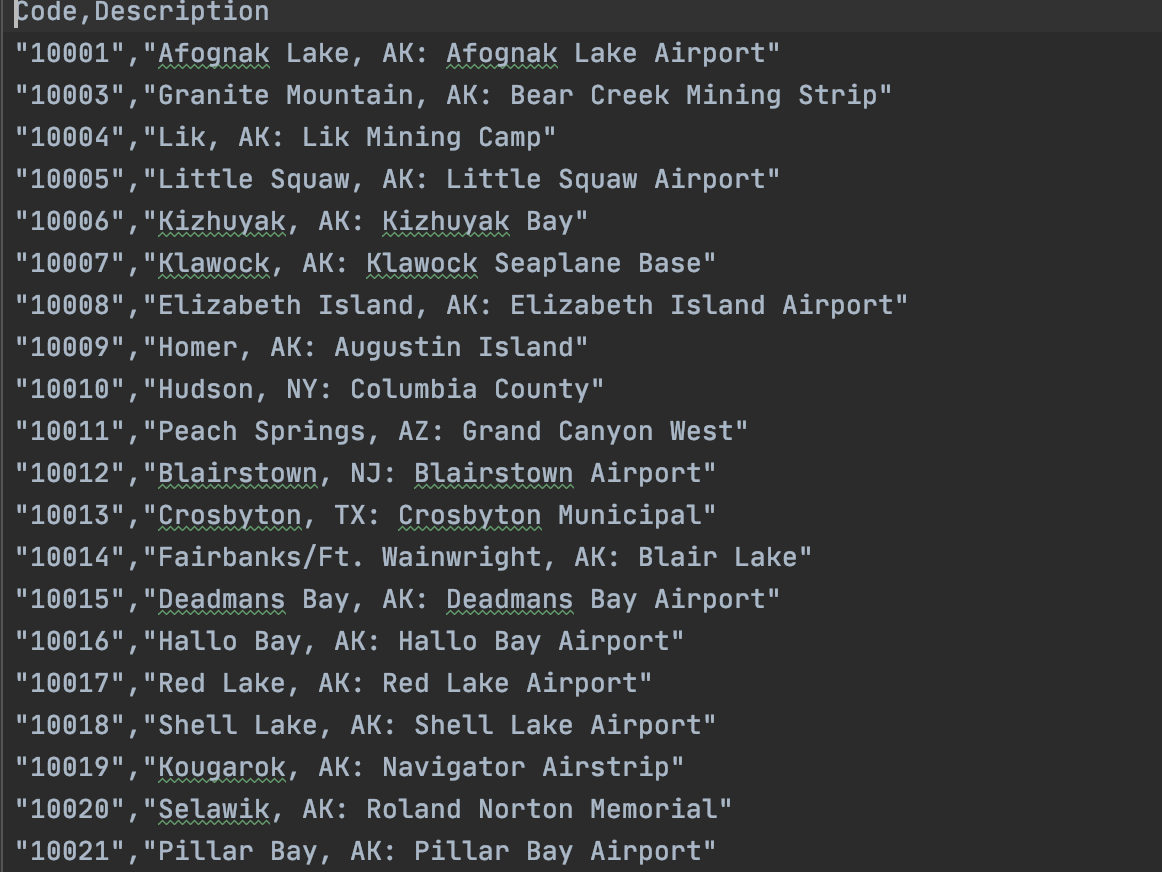

In [2]:
from IPython.display import Image
Image(filename='../images/airport_id.png')

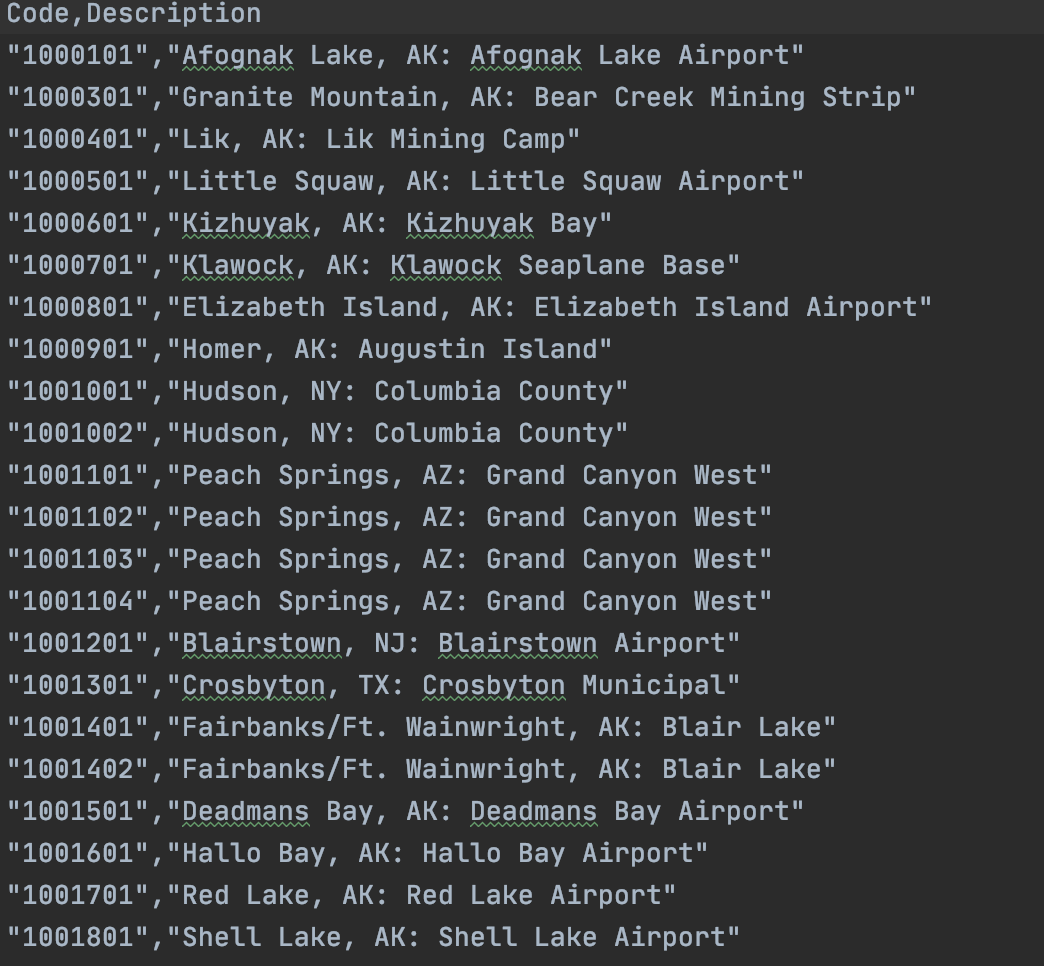

In [3]:
Image(filename='../images/airport__seq_id.png')

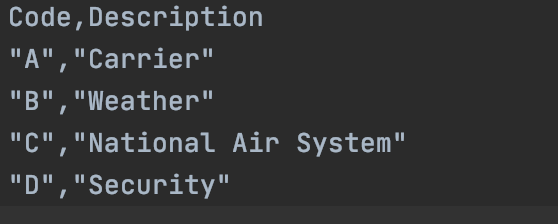

In [4]:
Image(filename='../images/cancellation.png')

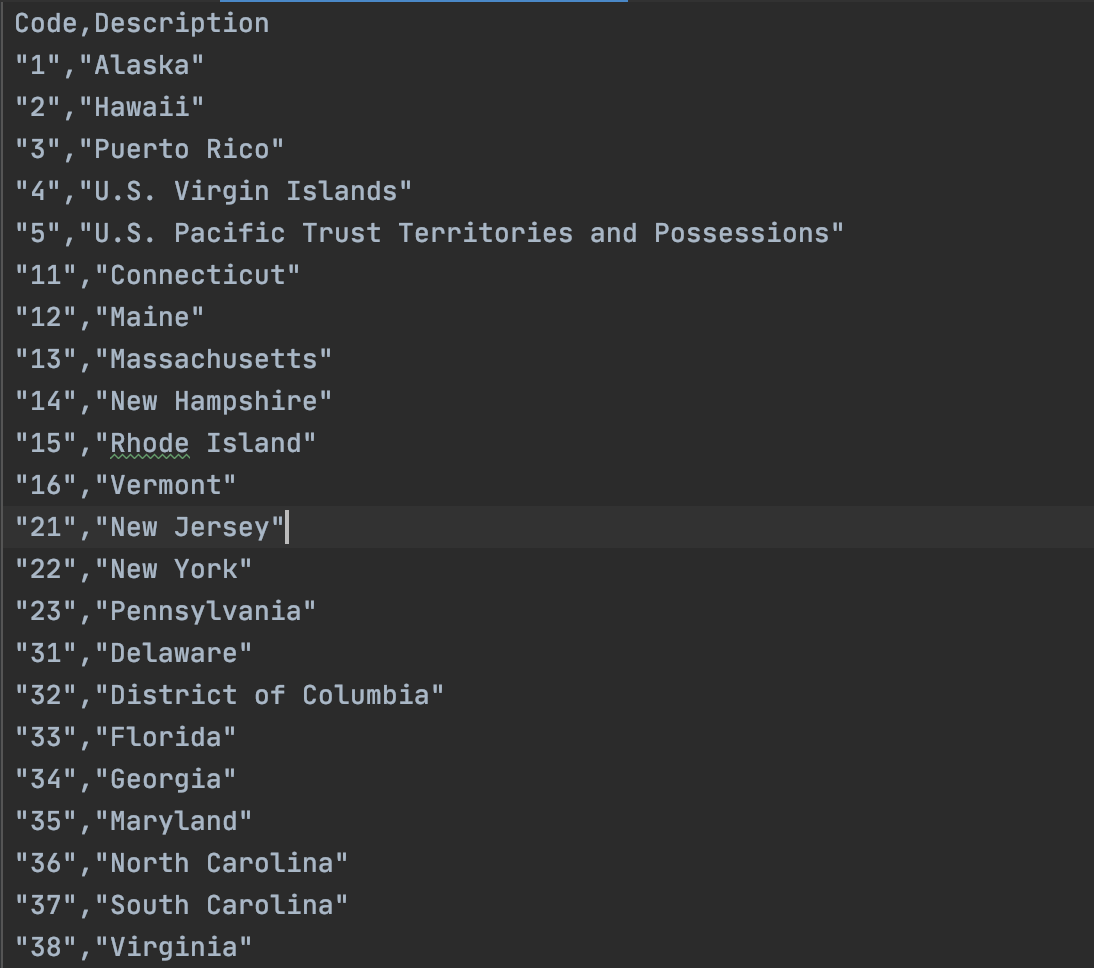

In [5]:

Image(filename='../images/wac.png')

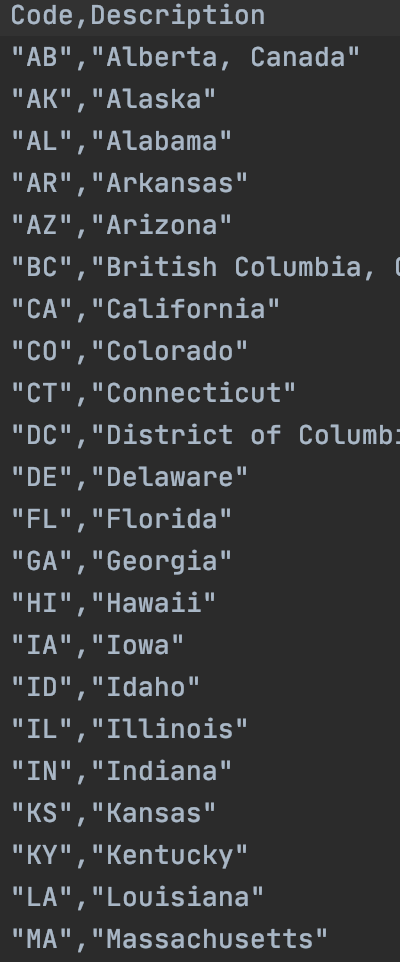

In [6]:

Image(filename='../images/state_abbr.png')

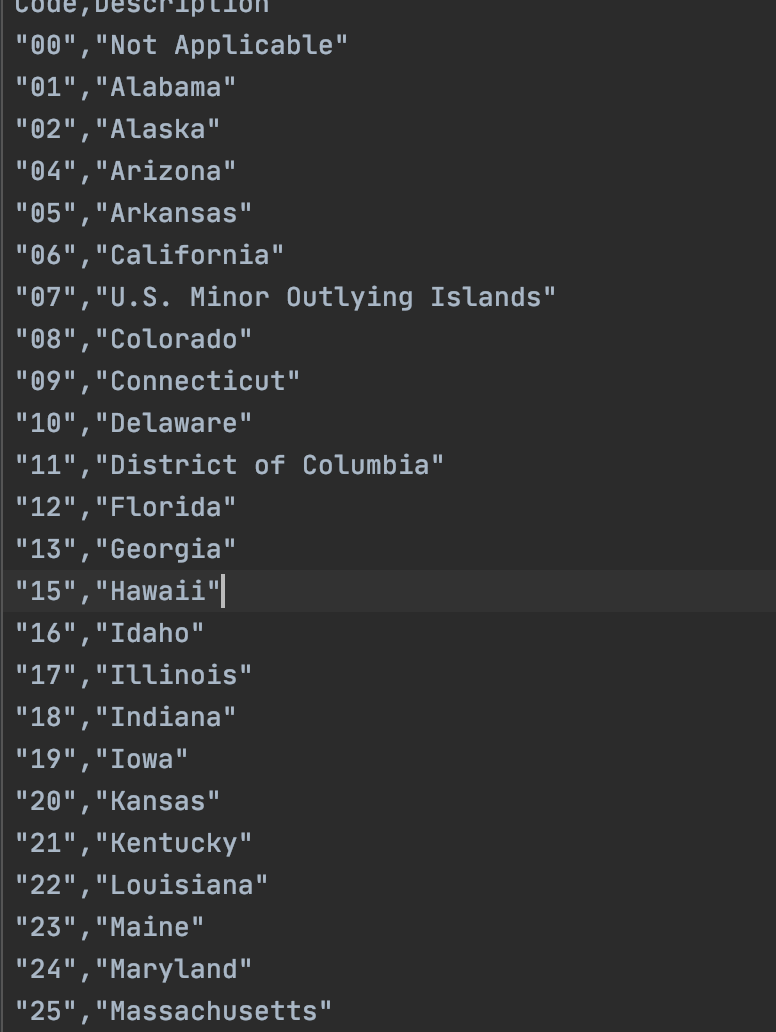

In [7]:
Image(filename='../images/state_fips.png')

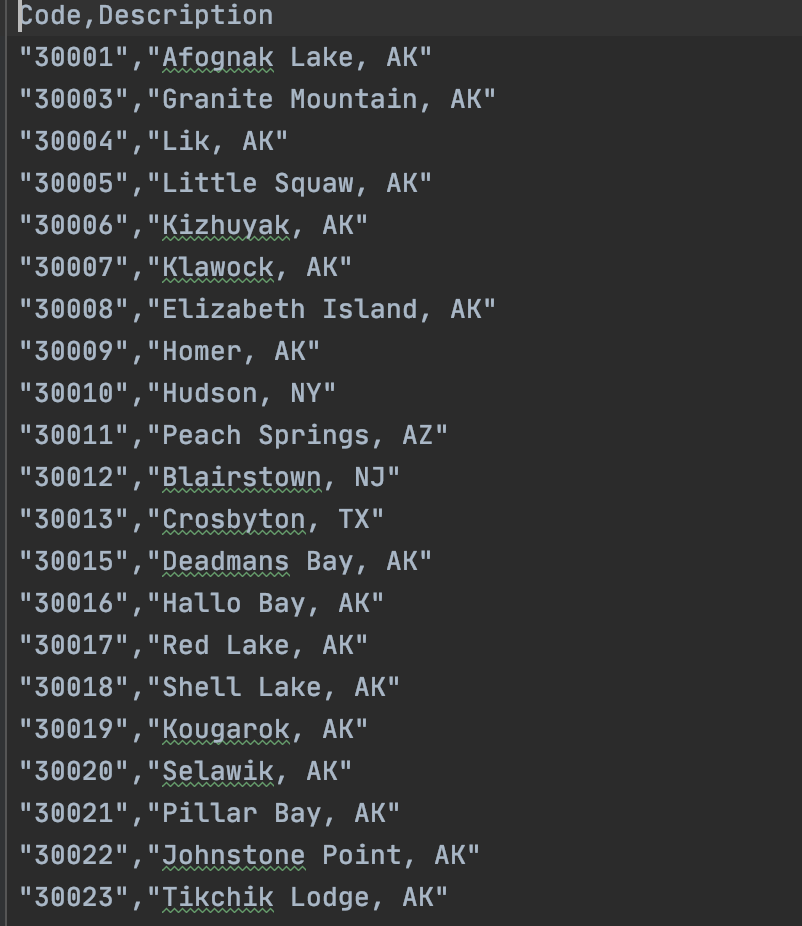

In [8]:
Image(filename='../images/city_market.png')

In [ ]:
# Check for nullability
null_count_flights = df_flights_january.isnull().sum()
print(null_count_flights)

In [ ]:
# Check for nullability
null_count_flights = df_flights_january.isnull().sum()
print(null_count_flights)

In [ ]:
# Check for nullability
null_count_flights = df_flights_january.isnull().sum()
print(null_count_flights)

In [ ]:
# Check for nullability
null_count_flights = df_flights_january.isnull().sum()
print(null_count_flights)

In [ ]:
# Check for nullability
null_count_flights = df_flights_january.isnull().sum()
print(null_count_flights)

In [ ]:
# Check for nullability
null_count_flights = df_flights_january.isnull().sum()
print(null_count_flights)

In [ ]:
# Check for nullability
null_count_flights = df_flights_january.isnull().sum()
print(null_count_flights)

In [7]:
# Check for nullability
null_count_flights = df_flights_january.isnull().sum()
print(null_count_flights)

FL_DATE                       0
OP_UNIQUE_CARRIER             0
TAIL_NUM                    698
ORIGIN_AIRPORT_ID             0
ORIGIN_AIRPORT_SEQ_ID         0
ORIGIN_CITY_MARKET_ID         0
ORIGIN                        0
ORIGIN_CITY_NAME              0
ORIGIN_STATE_ABR              0
ORIGIN_STATE_FIPS             0
ORIGIN_STATE_NM               0
ORIGIN_WAC                    0
DEST_AIRPORT_ID               0
DEST_AIRPORT_SEQ_ID           0
DEST_CITY_MARKET_ID           0
DEST                          0
DEST_CITY_NAME                0
DEST_STATE_ABR                0
DEST_STATE_FIPS               0
DEST_STATE_NM                 0
DEST_WAC                      0
DEP_TIME                   6664
DEP_DELAY                  6699
DEP_DELAY_NEW              6699
DEP_DEL15                  6699
ARR_TIME                   7075
ARR_DELAY                  8078
ARR_DELAY_NEW              8078
ARR_DEL15                  8078
CANCELLED                     0
CANCELLATION_CODE        600418
Unnamed:

In [14]:
# Check for nullability
null_count_covid = covid.isnull().sum()
print(null_count_covid)


In [8]:
null_delays=df_flights_january[df_flights_january['ARR_DEL15'].isnull()]
null_delays.head()

,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,CANCELLED,CANCELLATION_CODE,Unnamed: 31
35,2020-01-01,WN,N7831B,14057,1405702,34057,PDX,"Portland, OR",OR,41,Oregon,92,12889,1288903,32211,LAS,"Las Vegas, NV",NV,32,Nevada,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,A,NaN
38,2020-01-01,WN,N8678E,14057,1405702,34057,PDX,"Portland, OR",OR,41,Oregon,92,13232,1323202,30977,MDW,"Chicago, IL",IL,17,Illinois,41,543.0,-2.0,0.0,0.0,-1.0,NaN,NaN,NaN,0.0,NaN,NaN
839,2020-01-01,WN,N488WN,14908,1490803,32575,SNA,"Santa Ana, CA",CA,6,California,91,13796,1379608,32457,OAK,"Oakland, CA",CA,6,California,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,A,NaN
2026,2020-01-01,AA,N863NN,13204,1320402,31454,MCO,"Orlando, FL",FL,12,Florida,33,13303,1330303,32467,MIA,"Miami, FL",FL,12,Florida,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,A,NaN
2027,2020-01-01,AA,N863NN,13303,1330303,32467,MIA,"Miami, FL",FL,12,Florida,33,13204,1320402,31454,MCO,"Orlando, FL",FL,12,Florida,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,A,NaN


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession \
        .builder \
        .config("spark.jars.packages",
                "org.apache.hadoop:hadoop-aws:2.7.0",
                ) \
        .config("spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version", "2") \
        .getOrCreate()


### Step 2: Explore and Assess the Data, Define Models
NOTE: To enable proper loading of the data to redshift the parquet file needs to keep the columns which we partition with,
otherwise redshift ignores them. In our case because we partition by month and year we create two extra partition columns
_month and _year and use them as partition columns
#### Cleaning Steps covid and creating model
 * rename fields to reasonable names
 * cast values to proper int
 * cast dateRep to proper date value
 * lowercase all columns
 * create extra columns for partitioning

In [5]:
df = spark.read.json(cname, multiLine=True)
records_exploded = df.select(F.explode("records").alias("records")).cache()
# rename and cast fields
records_select = records_exploded.selectExpr(
        "records.countriesAndTerritories as country", "records.continentExp as continent",
        "records.geoId", "cast(records.cases as int)",
        "cast(records.deaths as int)", "records.dateRep", "cast(records.day as int)", "cast(records.month as int)",
        "cast(records.year as int)")
records_final = records_select.withColumn("dateRep", F.to_date("dateRep", "dd/MM/yyyy"))\
        .withColumn("_year", F.col("year")).withColumn("_month", F.col("month"))

records_final_lower = records_final.toDF(*[c.lower() for c in records_final.columns])
records_final_lower.printSchema()
records_final_lower.head()

root
 |-- country: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- geoid: string (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- daterep: date (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- _year: integer (nullable = true)
 |-- _month: integer (nullable = true)



Row(country='Afghanistan', continent='Asia', geoid='AF', cases=369, deaths=5, daterep=datetime.date(2020, 5, 11), day=11, month=5, year=2020, _year=2020, _month=5)

#### Cleaning Steps flights and creating model
 * define proper data schema and types
 * cast values to proper int
 * cast dateRep to proper date value
 * cast the cancelled field to boolean
 * lowercase all columns

In [7]:
data_sparkhema = [StructField('FL_DATE', DateType(), True),
                      StructField('OP_UNIQUE_CARRIER', StringType(), True),
                      StructField('TAIL_NUM', StringType(), True),
                      StructField('ORIGIN_AIRPORT_ID', IntegerType(), True),
                      StructField('ORIGIN_AIRPORT_SEQ_ID', IntegerType(), True),
                      StructField('ORIGIN_CITY_MARKET_ID', IntegerType(), True),
                      StructField('ORIGIN', StringType(), True),
                      StructField('ORIGIN_CITY_NAME', StringType(), True),
                      StructField('ORIGIN_STATE_ABR', StringType(), True),
                      StructField('ORIGIN_STATE_FIPS', StringType(), True),
                      StructField('ORIGIN_STATE_NM', StringType(), True),
                      StructField('ORIGIN_WAC', StringType(), True),
                      StructField('DEST_AIRPORT_ID', IntegerType(), True),
                      StructField('DEST_AIRPORT_SEQ_ID', IntegerType(), True),
                      StructField('DEST_CITY_MARKET_ID', IntegerType(), True),
                      StructField('DEST', StringType(), True),
                      StructField('DEST_CITY_NAME', StringType(), True),
                      StructField('DEST_STATE_ABR', StringType(), True),
                      StructField('DEST_STATE_FIPS', StringType(), True),
                      StructField('DEST_STATE_NM', StringType(), True),
                      StructField('DEST_WAC', StringType(), True),
                      StructField('DEP_TIME', StringType(), True),
                      StructField('DEP_DELAY', FloatType(), True),
                      StructField('DEP_DELAY_NEW', FloatType(), True),
                      StructField('DEP_DEL15', FloatType(), True),
                      StructField('ARR_TIME', StringType(), True),
                      StructField('ARR_DELAY', FloatType(), True),
                      StructField('ARR_DELAY_NEW', FloatType(), True),
                      StructField('ARR_DEL15', FloatType(), True),
                      StructField('CANCELLED', FloatType(), True),
                      StructField('CANCELLATION_CODE', StringType(), True),
                      ]
spark_schema = StructType(data_sparkhema)
df = spark.read.csv(flights_jan, header=True, schema=spark_schema)
year_month = df.withColumn('YEAR', F.year('FL_DATE')) \
        .withColumn('MONTH', F.month('FL_DATE'))\
        .withColumn('CANCELLED', F.col('CANCELLED').cast(BooleanType()))
df_lower = year_month.toDF(*[c.lower() for c in year_month.columns])
df_lower.printSchema()
df_lower.head()

root
 |-- fl_date: date (nullable = true)
 |-- op_unique_carrier: string (nullable = true)
 |-- tail_num: string (nullable = true)
 |-- origin_airport_id: integer (nullable = true)
 |-- origin_airport_seq_id: integer (nullable = true)
 |-- origin_city_market_id: integer (nullable = true)
 |-- origin: string (nullable = true)
 |-- origin_city_name: string (nullable = true)
 |-- origin_state_abr: string (nullable = true)
 |-- origin_state_fips: string (nullable = true)
 |-- origin_state_nm: string (nullable = true)
 |-- origin_wac: string (nullable = true)
 |-- dest_airport_id: integer (nullable = true)
 |-- dest_airport_seq_id: integer (nullable = true)
 |-- dest_city_market_id: integer (nullable = true)
 |-- dest: string (nullable = true)
 |-- dest_city_name: string (nullable = true)
 |-- dest_state_abr: string (nullable = true)
 |-- dest_state_fips: string (nullable = true)
 |-- dest_state_nm: string (nullable = true)
 |-- dest_wac: string (nullable = true)
 |-- dep_time: string (null

Row(fl_date=datetime.date(2020, 1, 1), op_unique_carrier='WN', tail_num='N951WN', origin_airport_id=13891, origin_airport_seq_id=1389101, origin_city_market_id=32575, origin='ONT', origin_city_name='Ontario, CA', origin_state_abr='CA', origin_state_fips='06', origin_state_nm='California', origin_wac='91', dest_airport_id=14771, dest_airport_seq_id=1477104, dest_city_market_id=32457, dest='SFO', dest_city_name='San Francisco, CA', dest_state_abr='CA', dest_state_fips='06', dest_state_nm='California', dest_wac='91', dep_time='1851', dep_delay=41.0, dep_delay_new=41.0, dep_del15=1.0, arr_time='2053', arr_delay=68.0, arr_delay_new=68.0, arr_del15=1.0, cancelled=False, cancellation_code=None, year=2020, month=1)

### Step 3: Define the Data Model

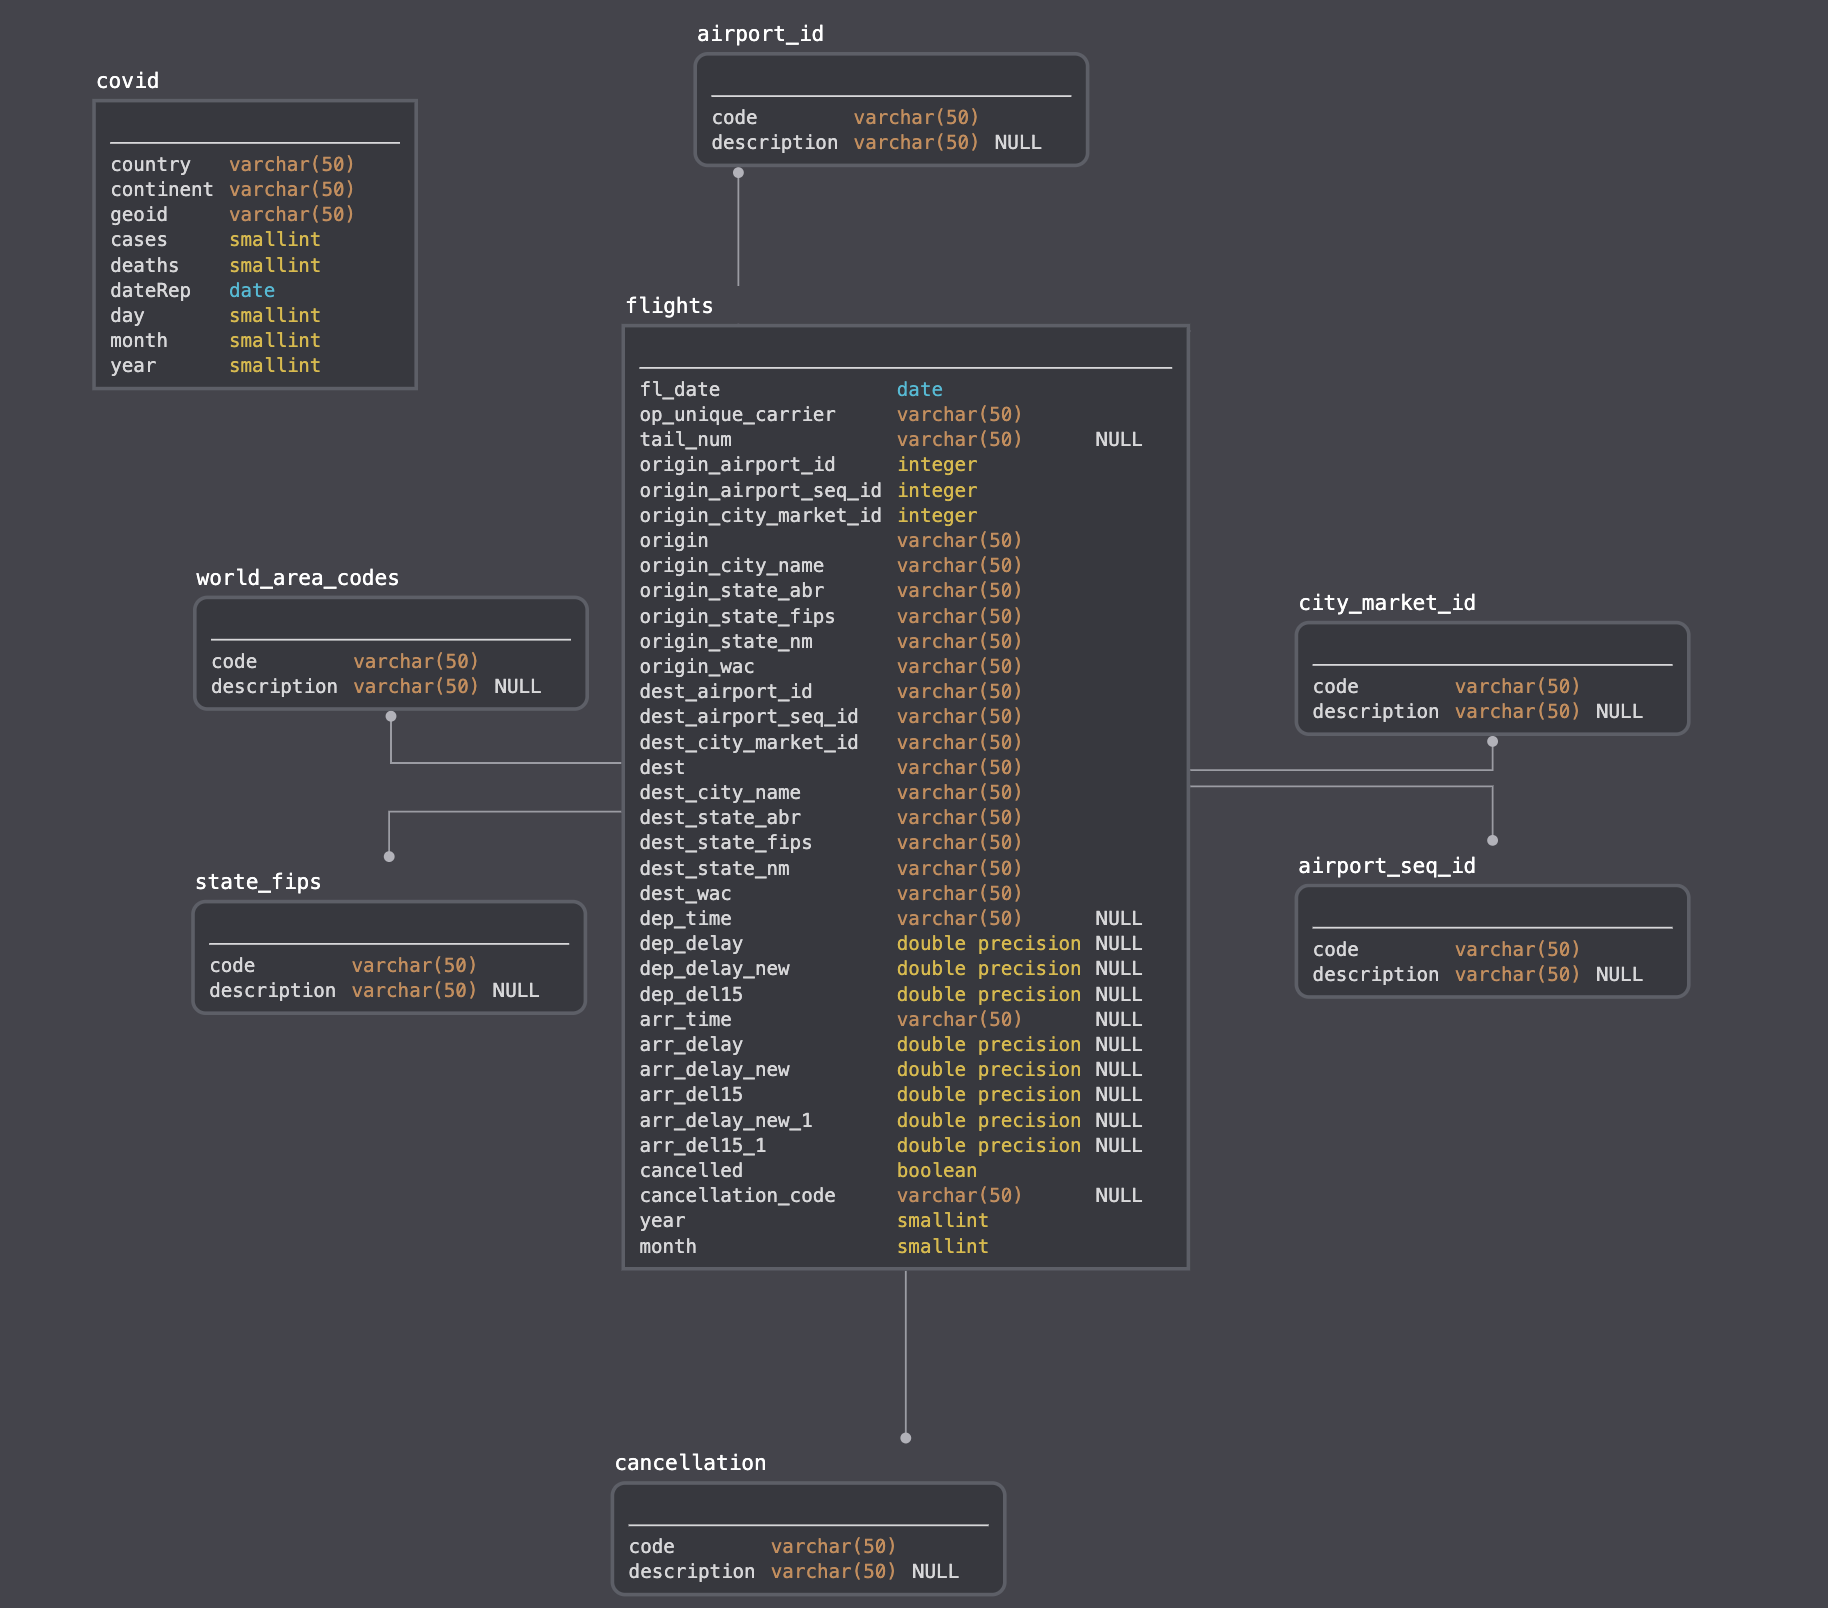

In [6]:
from IPython.display import Image
Image(filename='../images/data_model.jpg')

### Step 4: Run Pipelines to Model the Data 
## Emr Spark pipeline

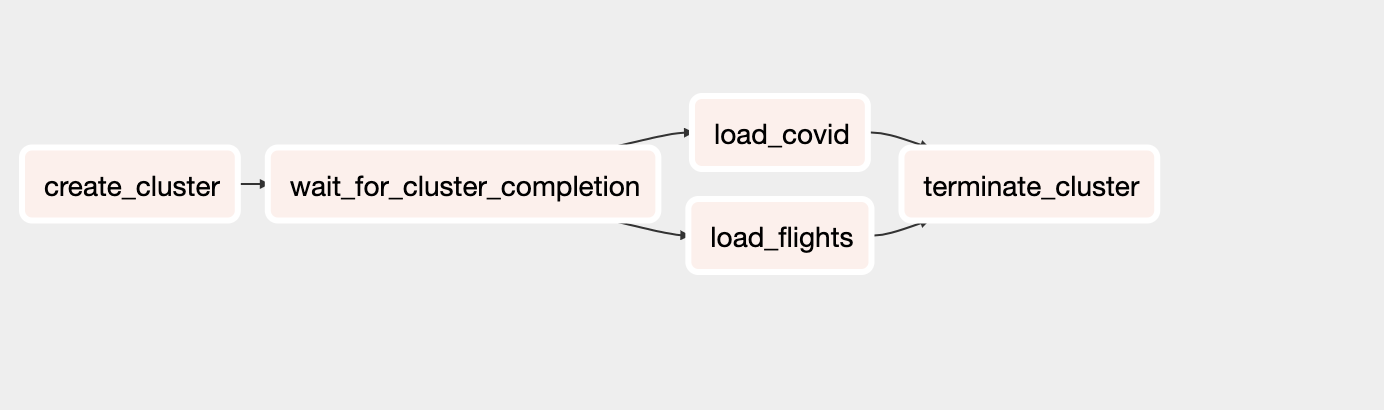

In [2]:
from IPython.display import Image
Image(filename='../images/emr_pipeline.jpg')

Using emr, livy to submit tasks and airflow to schedule the workflow
the first step is running an ETL process on the raw data which are downloaded and
stored in an s3 bucket, creating the required models and persisting in a partitioned parquet format
back in s3. The spark code follows these guidelines [best practices writing production spark](https://developerzen.com/best-practices-writing-production-grade-pyspark-jobs-cb688ac4d20f)
and a makefile is used to zip all the jobs to a separate jobs.zip file. Same goes for all externally used libraries. Following
these practices it becomes easy to submit spark jobs passing the zips in the --py-files argument of spark-submit and all
required arguments via the --args

## Parquet to redshift

After the data is persisted in s3 a separate airflow job is responsible for
copying the data over s3, creating the required fact and dimension tables and
running data checks and analytical queries.

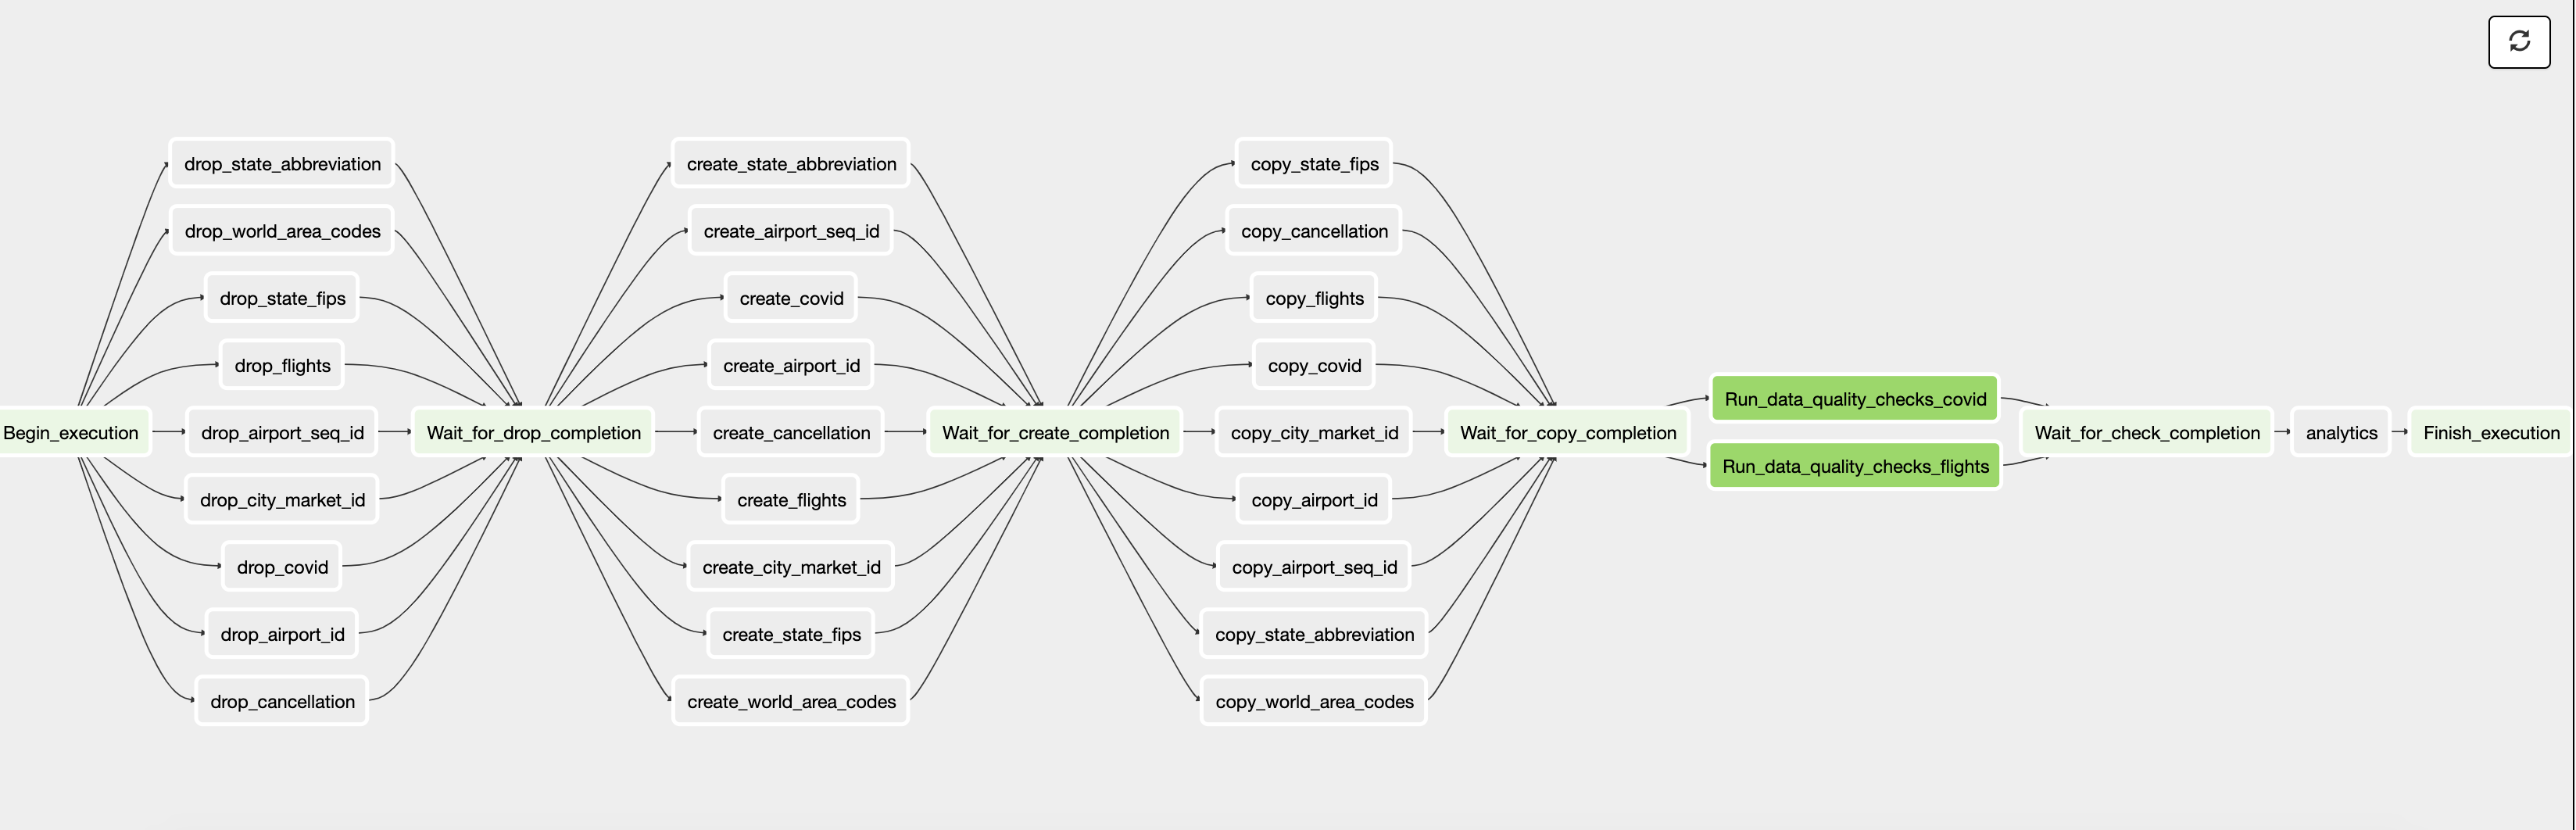

In [3]:
from IPython.display import Image
Image(filename='../images/data_pipeline.jpg')

## Analytics
After the redshift is populated we can run analytical queries on the data.

An example
is the following query which can be later used to create a dashboard containing
how the number of covid cases and deaths affect the
number of flights per origin in the United States every day

``` mysql
with covid_daily as ( select daterep,country,cases,deaths  from  covid where country='United_States_of_America' group by daterep,country,cases,deaths ),
flights_agg as (select origin,fl_date,count(origin) as num from flights group by origin,fl_date )
select * from covid_daily cd join flights_agg fa on cd.daterep=fa.fl_date order by cd.daterep desc;
```


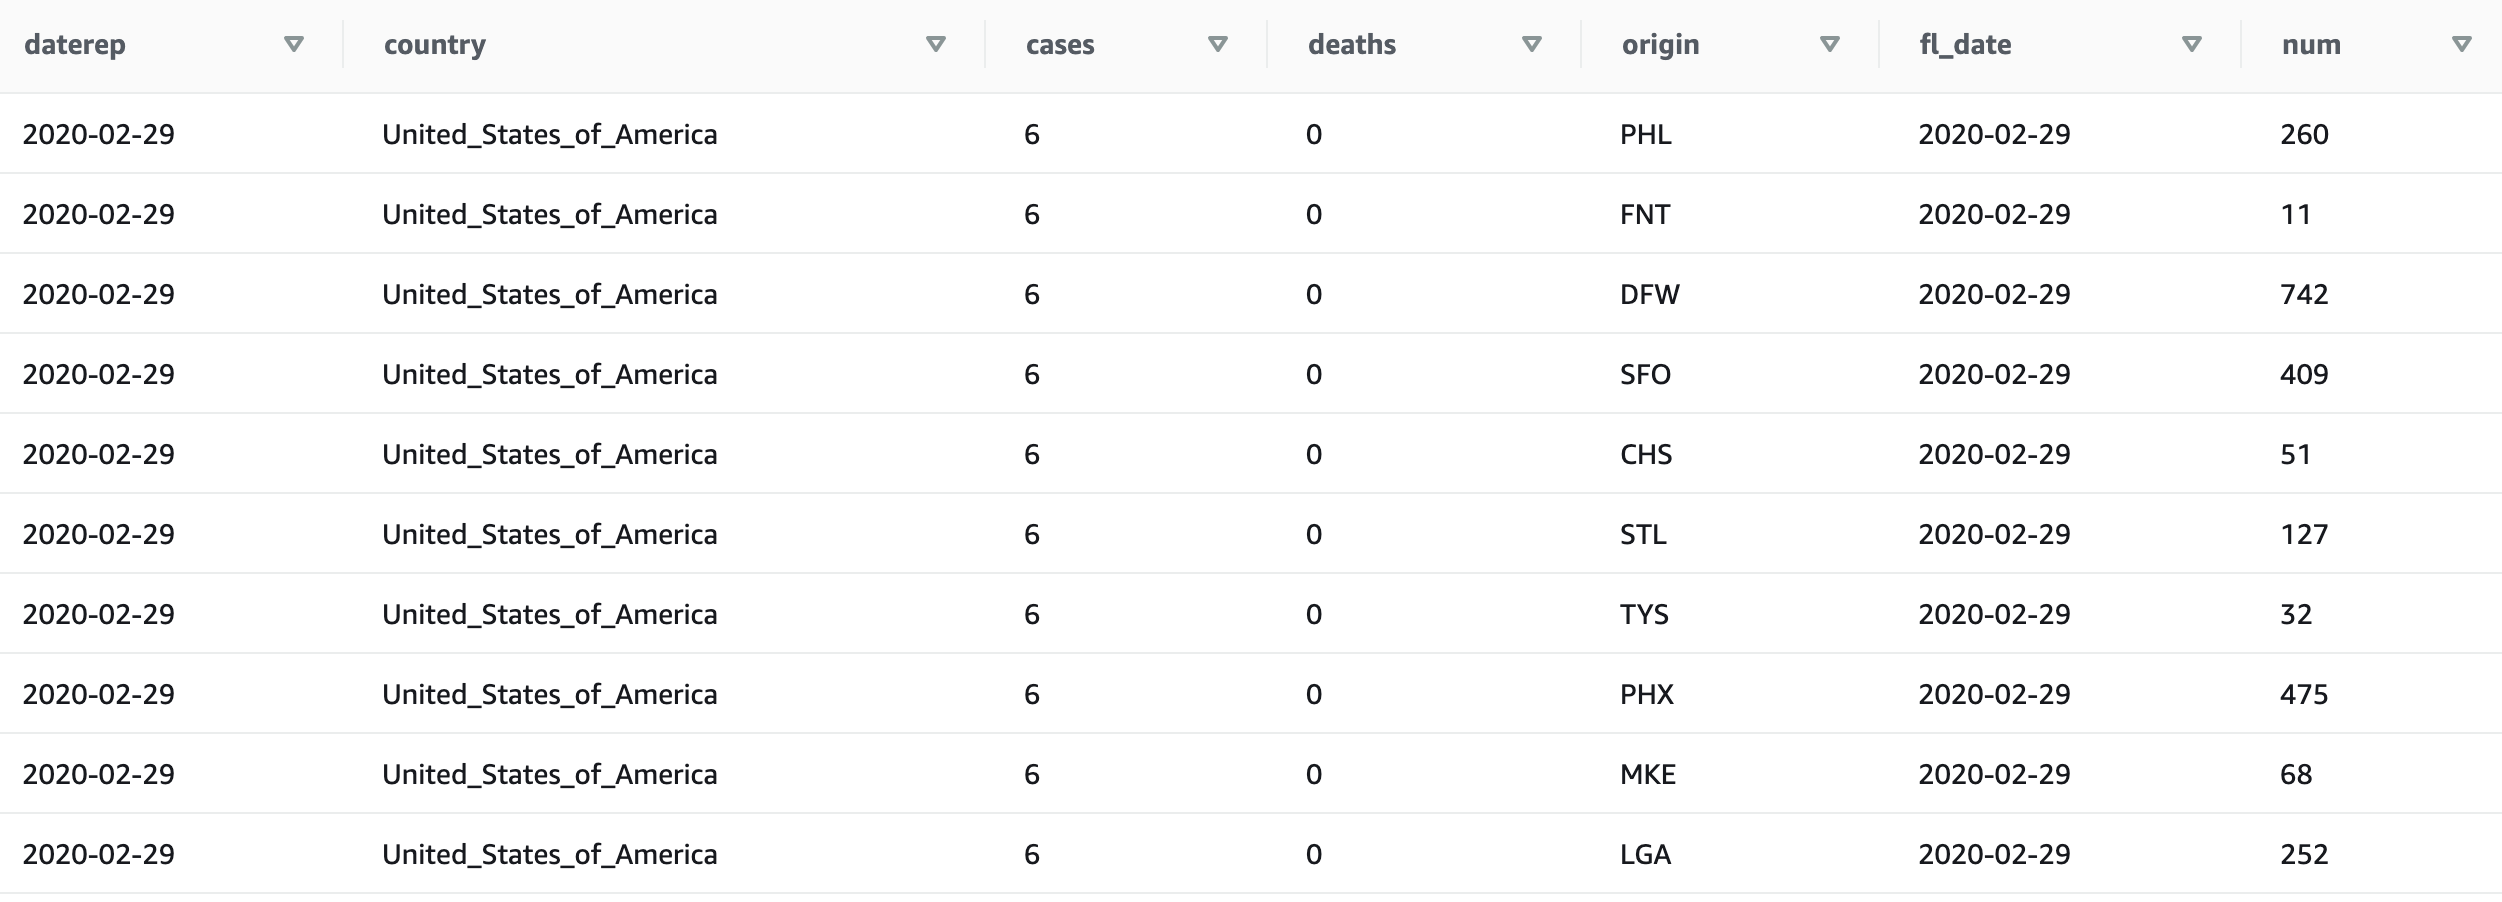

In [1]:
from IPython.display import Image
Image(filename='../images/redshift.jpg')

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

The technologies used in this project are the following:
* Airflow to orchestrate the workflows
* AWS EMR to run spark jobs
* Livy to expose a REST api to schedule spark jobs
* AWS Redshift to run analytical queries on the data

Since the covid data is updated daily on the website it makes sense to create a daily job
to pull the new json file with fresh cases data and overwrite the existing file.

Scale assumptions:
 If data increased by 100x :
  Bigger Spark cluster to distribute more efficiently the work.
  Same for airflow (would probably used a k8s executor system to scale up and down at will)
 If the data populates a dashboard that must be updated on a daily basis by 7am every day:
  If the data load becomes to large I would pre aggregate the analytic results and store them separately.
  Since old data is not changed i would only have to update fresh data of the last days and that would save compute time.
  Airflow would be scheduled to run the previous night and would try to optimize the data gathering part
  so we know exactly when the new data is available for download. Important to consider is timezones
  and whether the prioritization is a specific continent or country
 If the database needed to be accessed by 100+ people.
  The insights provided by redshift would not be directly accessed as it is not a transactional db and could be persisted in a fast
  relational or NoSQL database
  to allow great parallel reads. AWS aurora is an easy to use scalable relation database,
  but any good Postgres or Cassandra offering could serve 100 users without great provisioning

